In [1]:
# Import Packages
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import cv2
import glob
from keras.utils import plot_model
%matplotlib inline

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8775202056795117844
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15822330781336101497
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


In [3]:
# DeepFashion Dataset Path
train_path = '/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/train'
validation_path = '/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/validation'
test_path = '/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/test'

# Setting the Parameters & Hyperparameters

# 1
# img_row, img_col, img_channel = 224, 224, 3
# batch_size_train = 32
# batch_size_validation = 32
# epochs = 10
# category_nums = 50
# drop_rate = 0.25
# learning_rate = 0.001
# momentum_num = 0.99
# plot_num_rows = 3
# plot_num_rows = 3

# # 2
# img_row, img_col, img_channel = 224, 224, 3
# batch_size_train = 64
# batch_size_validation = 64
# epochs = 20
# category_nums = 50
# drop_rate = 0.25
# learning_rate = 0.0001
# momentum_num = 0.99
# plot_num_rows = 3
# plot_num_rows = 3

# # 3
# img_row, img_col, img_channel = 224, 224, 3
# batch_size_train = 64
# batch_size_validation = 64
# epochs = 3
# category_nums = 50
# drop_rate = 0.25
# learning_rate = 0.0001
# momentum_num = 0.99
# plot_num_rows = 3
# plot_num_rows = 3

# 4
img_row, img_col, img_channel = 224, 224, 3
batch_size_train = 64
batch_size_validation = 64
epochs = 10
category_nums = 50
drop_rate = 0.25
learning_rate = 0.0001
momentum_num = 0.99
plot_num_rows = 3
plot_num_rows = 3

In [4]:
# Initialize the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_row, img_col, img_channel))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ffb3f9766d8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffb3018fb00> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffb3015b898> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ffb30114c50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffb3011ed68> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffb3011e518> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ffb30125fd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffb300b2198> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffb300b2f28> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffb301289b0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ffb300b8dd8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffb300bf

In [5]:
def build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num):
    
    # Create the model
    model = tf.keras.models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    model.add(Dense(category_nums, activation='softmax'))

    # Compile the model with a SGD and a very slow learning rate
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [6]:
model = build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
Total params: 40,461,170
Trainable params: 40,459,122
Non-trainable params: 2,048
________________________________________

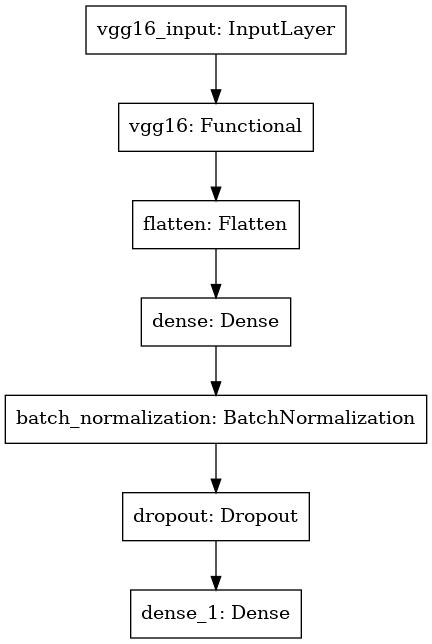

In [8]:
# Show a summary of the model
plot_model(model, to_file='/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/plot/model_summary4.jpg')

In [9]:
def data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col):

    # Train
    imgdatagen_train = ImageDataGenerator(
        rescale=1./255
    )

    train_dataset = imgdatagen_train.flow_from_directory(
        train_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_train,
        class_mode='categorical',
        shuffle=True
    )

    # Validation
    imgdatagen_validatioin = ImageDataGenerator(
        rescale=1./255
    )

    validation_dataset = imgdatagen_validatioin.flow_from_directory(
        validation_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_validation,
        class_mode='categorical',
        shuffle=True
    )

    # Test
    imgdatagen_test = ImageDataGenerator(
        rescale=1./255
    )
    
    test_dataset = imgdatagen_test.flow_from_directory(
        test_path,
        target_size=(img_row, img_col),
        class_mode='categorical',
        shuffle=True
    )
    
    return train_dataset, validation_dataset, test_dataset

In [10]:
train_dataset, validation_dataset, test_dataset = data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col)

X_train, y_train = next(train_dataset)

print(X_train.shape)
print(y_train.shape)
print(y_train[1,:])

X_val, y_val = next(validation_dataset)

print(X_val.shape)
print(y_val.shape)

X_test, y_test = next(test_dataset)

print(X_test.shape)
print(y_test.shape)

Found 209222 images belonging to 50 classes.
Found 40000 images belonging to 50 classes.
Found 40000 images belonging to 50 classes.
(64, 224, 224, 3)
(64, 50)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0.]
(64, 224, 224, 3)
(64, 50)
(32, 224, 224, 3)
(32, 50)


In [11]:
# Class Distribution of Train dataset
train_dataset_class_indices = train_dataset.class_indices
print("class indices of train dataset: ",train_dataset_class_indices)

class indices of train dataset:  {'Anorak': 0, 'Blazer': 1, 'Blouse': 2, 'Bomber': 3, 'Button-Down': 4, 'Caftan': 5, 'Cape': 6, 'Capris': 7, 'Cardigan': 8, 'Chinos': 9, 'Coat': 10, 'Coverup': 11, 'Culottes': 12, 'Cutoffs': 13, 'Dress': 14, 'Flannel': 15, 'Gauchos': 16, 'Halter': 17, 'Henley': 18, 'Hoodie': 19, 'Jacket': 20, 'Jeans': 21, 'Jeggings': 22, 'Jersey': 23, 'Jodhpurs': 24, 'Joggers': 25, 'Jumpsuit': 26, 'Kaftan': 27, 'Kimono': 28, 'Leggings': 29, 'Nightdress': 30, 'Onesie': 31, 'Parka': 32, 'Peacoat': 33, 'Poncho': 34, 'Robe': 35, 'Romper': 36, 'Sarong': 37, 'Shirtdress': 38, 'Shorts': 39, 'Skirt': 40, 'Sundress': 41, 'Sweater': 42, 'Sweatpants': 43, 'Sweatshorts': 44, 'Tank': 45, 'Tee': 46, 'Top': 47, 'Trunks': 48, 'Turtleneck': 49}


In [12]:
# print(train_dataset.filenames[:20])

category_names = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']

category_nums = {}

for filename in train_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))


[('Dress', 52137), ('Tee', 26652), ('Blouse', 17751), ('Shorts', 14194), ('Tank', 11203), ('Skirt', 10793), ('Cardigan', 9605), ('Sweater', 9516), ('Jacket', 7547), ('Top', 7269), ('Romper', 5424), ('Blazer', 5407), ('Jeans', 5125), ('Jumpsuit', 4463), ('Leggings', 3570), ('Joggers', 3259), ('Hoodie', 2909), ('Sweatpants', 2223), ('Kimono', 1636), ('Coat', 1538), ('Cutoffs', 1176), ('Sweatshorts', 780), ('Poncho', 578), ('Jersey', 533), ('Henley', 520), ('Parka', 490), ('Jeggings', 442), ('Chinos', 373), ('Culottes', 358), ('Trunks', 286), ('Button-Down', 242), ('Bomber', 228), ('Flannel', 223), ('Anorak', 120), ('Robe', 106), ('Turtleneck', 98), ('Kaftan', 97), ('Peacoat', 62), ('Capris', 56), ('Onesie', 46), ('Caftan', 37), ('Gauchos', 34), ('Jodhpurs', 31), ('Sarong', 17), ('Coverup', 12), ('Halter', 10)]
209176


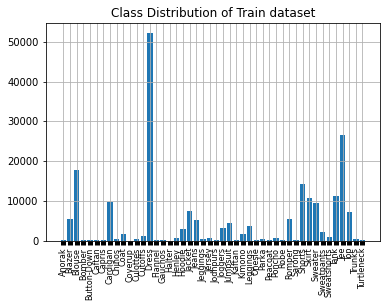

In [13]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of Train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [14]:
# Class Distribution of validation dataset
validation_dataset_class_indices = validation_dataset.class_indices
print("class indices of validation dataset: ", validation_dataset_class_indices)

class indices of validation dataset:  {'Anorak': 0, 'Blazer': 1, 'Blouse': 2, 'Bomber': 3, 'Button-Down': 4, 'Caftan': 5, 'Cape': 6, 'Capris': 7, 'Cardigan': 8, 'Chinos': 9, 'Coat': 10, 'Coverup': 11, 'Culottes': 12, 'Cutoffs': 13, 'Dress': 14, 'Flannel': 15, 'Gauchos': 16, 'Halter': 17, 'Henley': 18, 'Hoodie': 19, 'Jacket': 20, 'Jeans': 21, 'Jeggings': 22, 'Jersey': 23, 'Jodhpurs': 24, 'Joggers': 25, 'Jumpsuit': 26, 'Kaftan': 27, 'Kimono': 28, 'Leggings': 29, 'Nightdress': 30, 'Onesie': 31, 'Parka': 32, 'Peacoat': 33, 'Poncho': 34, 'Robe': 35, 'Romper': 36, 'Sarong': 37, 'Shirtdress': 38, 'Shorts': 39, 'Skirt': 40, 'Sundress': 41, 'Sweater': 42, 'Sweatpants': 43, 'Sweatshorts': 44, 'Tank': 45, 'Tee': 46, 'Top': 47, 'Trunks': 48, 'Turtleneck': 49}


In [15]:
category_names = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']

category_nums = {}

for filename in validation_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

[('Dress', 10051), ('Tee', 5142), ('Blouse', 3388), ('Shorts', 2699), ('Tank', 2096), ('Skirt', 2045), ('Cardigan', 1827), ('Sweater', 1821), ('Jacket', 1472), ('Top', 1396), ('Blazer', 1039), ('Romper', 988), ('Jeans', 964), ('Jumpsuit', 839), ('Leggings', 717), ('Joggers', 580), ('Hoodie', 540), ('Sweatpants', 415), ('Kimono', 318), ('Coat', 276), ('Cutoffs', 248), ('Sweatshorts', 164), ('Jersey', 107), ('Poncho', 105), ('Parka', 97), ('Henley', 88), ('Jeggings', 86), ('Chinos', 79), ('Trunks', 57), ('Culottes', 55), ('Flannel', 48), ('Bomber', 40), ('Button-Down', 40), ('Robe', 21), ('Turtleneck', 17), ('Peacoat', 16), ('Anorak', 15), ('Onesie', 11), ('Capris', 10), ('Kaftan', 10), ('Sarong', 7), ('Caftan', 6), ('Gauchos', 5), ('Jodhpurs', 4), ('Halter', 3), ('Coverup', 2)]
39954


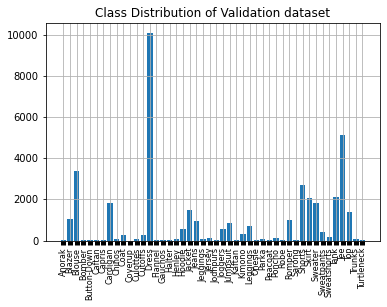

In [16]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of Validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [17]:
test_dataset_class_indices = test_dataset.class_indices
print("class indices of test dataset: ", test_dataset_class_indices)

class indices of test dataset:  {'Anorak': 0, 'Blazer': 1, 'Blouse': 2, 'Bomber': 3, 'Button-Down': 4, 'Caftan': 5, 'Cape': 6, 'Capris': 7, 'Cardigan': 8, 'Chinos': 9, 'Coat': 10, 'Coverup': 11, 'Culottes': 12, 'Cutoffs': 13, 'Dress': 14, 'Flannel': 15, 'Gauchos': 16, 'Halter': 17, 'Henley': 18, 'Hoodie': 19, 'Jacket': 20, 'Jeans': 21, 'Jeggings': 22, 'Jersey': 23, 'Jodhpurs': 24, 'Joggers': 25, 'Jumpsuit': 26, 'Kaftan': 27, 'Kimono': 28, 'Leggings': 29, 'Nightdress': 30, 'Onesie': 31, 'Parka': 32, 'Peacoat': 33, 'Poncho': 34, 'Robe': 35, 'Romper': 36, 'Sarong': 37, 'Shirtdress': 38, 'Shorts': 39, 'Skirt': 40, 'Sundress': 41, 'Sweater': 42, 'Sweatpants': 43, 'Sweatshorts': 44, 'Tank': 45, 'Tee': 46, 'Top': 47, 'Trunks': 48, 'Turtleneck': 49}


In [18]:
category_names = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']

category_nums = {}

for filename in test_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

[('Dress', 9967), ('Tee', 5090), ('Blouse', 3415), ('Shorts', 2770), ('Tank', 2127), ('Skirt', 1932), ('Cardigan', 1876), ('Sweater', 1783), ('Jacket', 1445), ('Top', 1410), ('Blazer', 1046), ('Romper', 993), ('Jeans', 984), ('Jumpsuit', 848), ('Leggings', 723), ('Hoodie', 596), ('Joggers', 574), ('Sweatpants', 407), ('Kimono', 337), ('Coat', 303), ('Cutoffs', 242), ('Sweatshorts', 159), ('Henley', 105), ('Jersey', 105), ('Poncho', 105), ('Parka', 86), ('Chinos', 72), ('Culottes', 70), ('Jeggings', 63), ('Flannel', 50), ('Button-Down', 45), ('Trunks', 40), ('Bomber', 38), ('Turtleneck', 28), ('Anorak', 22), ('Robe', 20), ('Kaftan', 16), ('Peacoat', 16), ('Onesie', 10), ('Caftan', 8), ('Capris', 8), ('Gauchos', 7), ('Jodhpurs', 7), ('Sarong', 5), ('Halter', 1), ('Coverup', 0)]
39954


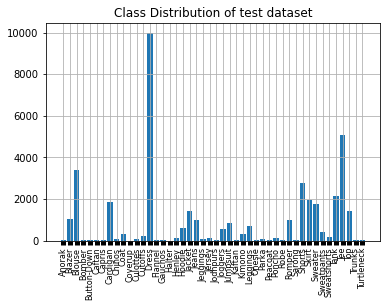

In [19]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of test dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [20]:
class_labels = list(validation_dataset.class_indices.keys())
num_imgs_validation = len(validation_dataset.filenames)
num_imgs_train = len(train_dataset.filenames)
num_imgs_test = len(test_dataset.filenames)
print("class_labels_keys: ", class_labels)
print("Length of class_labels: ", len(class_labels))
print("Number of train images: ", num_imgs_train)
print("Number of validation images: ", num_imgs_validation)
print("Number of test images: ", num_imgs_test)

class_labels_keys:  ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan', 'Cape', 'Capris', 'Cardigan', 'Chinos', 'Coat', 'Coverup', 'Culottes', 'Cutoffs', 'Dress', 'Flannel', 'Gauchos', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Jodhpurs', 'Joggers', 'Jumpsuit', 'Kaftan', 'Kimono', 'Leggings', 'Nightdress', 'Onesie', 'Parka', 'Peacoat', 'Poncho', 'Robe', 'Romper', 'Sarong', 'Shirtdress', 'Shorts', 'Skirt', 'Sundress', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee', 'Top', 'Trunks', 'Turtleneck']
Length of class_labels:  50
Number of train images:  209222
Number of validation images:  40000
Number of test images:  40000


In [21]:
# Plotting Accuracy & Loss Curves
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    val_acc = model_histories.history['val_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/plot/DeepFashionVGG16CurvesAcc4.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/plot/DeepFashionVGG16CurvesLoss4.jpg')
    plt.show()

In [22]:
# Register Callbacks
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/csvlogger/model_train4.csv'
    csv_log = tf.keras.callbacks.CSVLogger(filename, separator=' ', append=False)
    
    # EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=500, verbose=1, mode='min'
    )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/my_checkpoint4.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, early_stopping, check_point]
    return callback_list

In [23]:
callback_list = callback()

In [24]:
# Fine-tune the model - Training
def fit_model(model, train_dataset, X_val, y_val, batch_size_train, batch_size_validation, epochs):
    
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=(X_val, y_val),
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_dataset,
        verbose=1
    )

    return model, history, score

Epoch 1/10
3270/3270 [==============================] - 2789s 847ms/step - loss: 1.4858 - accuracy: 0.5924 - val_loss: 1.6511 - val_accuracy: 0.4688
Epoch 2/10
3270/3270 [==============================] - 2743s 839ms/step - loss: 0.9947 - accuracy: 0.7010 - val_loss: 1.1184 - val_accuracy: 0.6406
Epoch 3/10
3270/3270 [==============================] - 2739s 837ms/step - loss: 0.8780 - accuracy: 0.7323 - val_loss: 1.0730 - val_accuracy: 0.7344
Epoch 4/10
3270/3270 [==============================] - 2731s 835ms/step - loss: 0.7647 - accuracy: 0.7648 - val_loss: 1.1040 - val_accuracy: 0.6562
Epoch 5/10
3270/3270 [==============================] - 2730s 835ms/step - loss: 0.6367 - accuracy: 0.7999 - val_loss: 1.2274 - val_accuracy: 0.6719
Epoch 6/10
3270/3270 [==============================] - 2725s 833ms/step - loss: 0.4812 - accuracy: 0.8464 - val_loss: 1.3072 - val_accuracy: 0.6719
Epoch 7/10
3270/3270 [==============================] - 2731s 835ms/step - loss: 0.3209 - accuracy: 0.8971

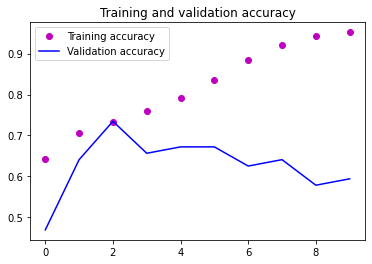

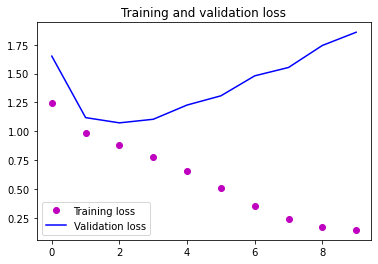

Validation Accuracy:0.6890249848365784 
Validation Loss:1.5817612409591675


In [25]:
model, history, score = fit_model(model, train_dataset, X_val, y_val, batch_size_train, batch_size_validation, epochs)

# Learning curves
curves(history, epochs)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))

In [26]:
# Prediction
model.load_weights('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/my_checkpoint4.ckpt')
Y_pred = model.predict(test_dataset)

In [27]:
testY_labels = test_dataset.labels
print(testY_labels)
print(len(testY_labels))

[ 0  0  0 ... 49 49 49]
40000


In [28]:
model.load_weights('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/my_checkpoint4.ckpt')

loss, acc = model.evaluate(X_test, y_test)
print("loss: ", loss)
print("acc: ", acc)

1/1 [==============================] - 0s 154ms/step - loss: 0.5444 - accuracy: 0.8750
loss:  0.5443730354309082
acc:  0.875


In [30]:
# Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/my_checkpoint4.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpj_hff_f5/assets


INFO:tensorflow:Assets written to: /tmp/tmpj_hff_f5/assets


161847192